In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%load_ext autoreload
%autoreload 2

## Metrics results class

### Metrics types

In [3]:
from pulsar_metrics.metrics.base import MetricsType

In [4]:
MetricsType._member_names_

['performance', 'drift', 'custom']

### Metric data structure

In [5]:
from pulsar_metrics.metrics.base import MetricResults

In [6]:
result = MetricResults(
    name="accuracy", type="performance", model_id="model_1", model_version=1, period_end=datetime(2022, 7, 1)
)
result

MetricResults(metric_name=None, type='performance', model_id='model_1', model_version='1', data_id=None, feature=None, value=None, status=None, threshold=None, period_start=None, period_end=datetime.datetime(2022, 7, 1, 0, 0), eval_timestamp=datetime.datetime(2022, 9, 26, 10, 28, 27, 846122), conf_int=None)

## Loading datasets

In [7]:
data_ref = pd.read_csv('california_ref.csv')
data_new = pd.read_csv('california_new.csv')

In [8]:
data_ref.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,pred_timestamp,period,clf_target,y_pred_proba,y_pred,identifier,model_id,model_version
0,9.8413,32.0,7.170040,1.014845,4353.0,2.937247,34.22,-118.19,2020-10-01 00:00:00,reference,1,0.99,1,0,1,2
1,8.3695,37.0,7.458746,1.062706,941.0,3.105611,34.22,-118.21,2020-10-01 01:00:00,reference,1,1.00,1,1,1,2
2,8.7200,44.0,6.163180,1.046025,668.0,2.794979,34.20,-118.18,2020-10-01 02:00:00,reference,1,1.00,1,2,1,2
3,7.4190,41.0,6.725166,0.973510,859.0,2.844371,34.20,-118.19,2020-10-01 03:00:00,reference,1,1.00,1,3,1,2
4,6.5530,41.0,7.120000,1.013333,680.0,3.022222,34.21,-118.19,2020-10-01 04:00:00,reference,1,1.00,1,4,1,2


## Drift Class

In [9]:
from pulsar_metrics.metrics.drift import DriftTestMetric, DriftMetric, DriftMetricsFuncs, DriftTestMetricsFuncs

In [10]:
DriftMetricsFuncs._member_names_

['kl', 'wasserstein']

In [11]:
DriftTestMetricsFuncs._member_names_

['ttest', 'manwu', 'levene', 'bftest', 'ks_2samp', 'CvM', 'chi2']

### Test Drift metrics

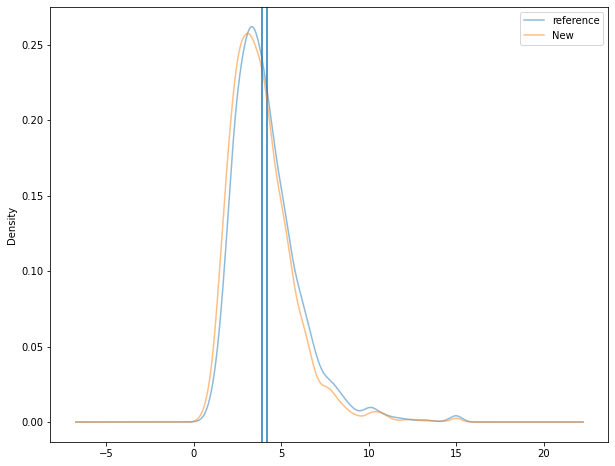

In [33]:
feature_name = 'MedInc'
#feature_name = 'Population'
fig, ax = plt.subplots(1, 1, figsize = (10, 8))
data_ref[feature_name].plot.density(ax = ax, alpha = 0.5, label = 'reference')
plt.axvline(data_ref[feature_name].mean())
data_new[feature_name].plot.density(ax = ax, alpha = 0.5, label = 'New')
plt.axvline(data_new[feature_name].mean())
#ax.set_xlim((0, 6000))
plt.legend()

In [31]:

driftTest = DriftTestMetric(name = 'ttest', data = data_new, feature_name = feature_name)
driftTest.evaluate(alpha = 0.05, reference = data_ref[feature_name])

MetricResults(metric_name='ttest', type='drift', model_id='1', model_version='2', data_id=None, feature='Population', value=0.012845290639447384, status=True, threshold=0.05, period_start=Timestamp('2021-06-01 00:00:00'), period_end=Timestamp('2022-05-09 23:00:00'), eval_timestamp=datetime.datetime(2022, 9, 26, 10, 28, 27, 846122), conf_int=None)

In [32]:
driftTest = DriftTestMetric(name = 'CvM', data = data_new, feature_name = feature_name)
driftTest.evaluate(alpha = 0.05, reference = data_ref[feature_name])

MetricResults(metric_name='CvM', type='drift', model_id='1', model_version='2', data_id=None, feature='Population', value=0.06844867814003908, status=False, threshold=0.05, period_start=Timestamp('2021-06-01 00:00:00'), period_end=Timestamp('2022-05-09 23:00:00'), eval_timestamp=datetime.datetime(2022, 9, 26, 10, 28, 27, 846122), conf_int=None)

### Non test drift metrics

In [15]:
drift = DriftMetric(name = 'kl', data = data_new, feature_name = feature_name)
drift.evaluate(reference = data_ref[feature_name], threshold = None)

MetricResults(metric_name='kl', type='drift', model_id='1', model_version='2', data_id=None, feature='MedInc', value=0.01881080682460068, status=None, threshold=None, period_start=Timestamp('2021-06-01 00:00:00'), period_end=Timestamp('2022-05-09 23:00:00'), eval_timestamp=datetime.datetime(2022, 9, 26, 10, 28, 27, 846122), conf_int=None)

## Custom metric class    

In [16]:
from pulsar_metrics.metrics.base import CustomMetric

In [17]:
@CustomMetric
def test_custom(a, b, **kwargs):
    return np.max(a - b)

In [18]:
cus = test_custom(name = 'test', data = data_ref)

In [19]:
cus.evaluate(a = 1, b = 2, threshold = 2)

MetricResults(metric_name='test', type='custom', model_id='1', model_version='2', data_id=None, feature=None, value=-1.0, status=True, threshold=2.0, period_start=Timestamp('2020-10-01 00:00:00'), period_end=Timestamp('2021-05-31 23:00:00'), eval_timestamp=datetime.datetime(2022, 9, 26, 10, 28, 27, 846122), conf_int=None)

## Performance metrics

### Implemented metrics

In [20]:
from pulsar_metrics.metrics.performance import PerformanceMetricsFuncs

In [21]:
PerformanceMetricsFuncs._member_names_

['accuracy',
 'precision',
 'recall',
 'f1',
 'log_loss',
 'auc',
 'aucpr',
 'brier',
 'mse',
 'mae',
 'mape',
 'r2']

### Exemple performance metric

In [22]:
from pulsar_metrics.metrics.performance import PerformanceMetric

In [23]:
precision = PerformanceMetric(name = 'precision', data = data_ref, y_name = 'clf_target')

In [24]:
precision.evaluate(bootstrap=True, average = 'micro', threshold = 0.5)

MetricResults(metric_name='precision', type='performance', model_id='1', model_version='2', data_id=None, feature='prediction', value=0.6704389574759945, status=False, threshold=0.5, period_start=Timestamp('2020-10-01 00:00:00'), period_end=Timestamp('2021-05-31 23:00:00'), eval_timestamp=datetime.datetime(2022, 9, 26, 10, 28, 27, 846122), conf_int=[0.6586462620027435, 0.68292609739369])

## Running an analyzer with multiple metrics

In [25]:
from pulsar_metrics.analyzers.base import Analyzer

In [26]:
analysis = Analyzer(name = 'First Analyzer', description='My first Analyzer', data = data_new)

In [27]:
analysis.add_drift_metrics(metrics_list=['wasserstein', 'ttest', 'ks_2samp'], features_list=['Population', 'MedInc']);
analysis.add_performance_metrics(metrics_list=['accuracy'], y_name = 'clf_target');

Drift metric 'wasserstein' for feature 'Population' added to the analyzer list
Drift metric 'wasserstein' for feature 'MedInc' added to the analyzer list
Drift metric 'ttest' for feature 'Population' added to the analyzer list
Drift metric 'ttest' for feature 'MedInc' added to the analyzer list
Drift metric 'ks_2samp' for feature 'Population' added to the analyzer list
Drift metric 'ks_2samp' for feature 'MedInc' added to the analyzer list
'clf_target'
The dataset contains no ground truth for performance assessment. Metric 'accuracy' was NOT added to the analyzer list


In [28]:
analysis.run(data_ref = data_ref, options = {'ttest': {'alpha': 0.01, 'equal_var': False}})

In [29]:
analysis.results_to_pandas()

,metric_name,type,model_id,model_version,data_id,feature,value,status,threshold,period_start,period_end,eval_timestamp,conf_int
0,wasserstein,drift,1,2,None,Population,5.258844e+01,None,NaN,2021-06-01,2022-05-09 23:00:00,2022-09-26 10:28:27.846122,None
1,wasserstein,drift,1,2,None,MedInc,3.047303e-01,None,NaN,2021-06-01,2022-05-09 23:00:00,2022-09-26 10:28:27.846122,None
2,ttest,drift,1,2,None,Population,1.284529e-02,False,0.01,2021-06-01,2022-05-09 23:00:00,2022-09-26 10:28:27.846122,None
3,ttest,drift,1,2,None,MedInc,4.860186e-21,True,0.01,2021-06-01,2022-05-09 23:00:00,2022-09-26 10:28:27.846122,None
4,ks_2samp,drift,1,2,None,Population,9.347256e-02,False,0.05,2021-06-01,2022-05-09 23:00:00,2022-09-26 10:28:27.846122,None
5,ks_2samp,drift,1,2,None,MedInc,2.997602e-14,True,0.05,2021-06-01,2022-05-09 23:00:00,2022-09-26 10:28:27.846122,None
